In [3]:
'''Zwischenschritt (nach Schritt 3)
Es wird geschaut, wo die ways mit dem meisten Messwerten liegen.
'''

'Zwischenschritt (nach Schritt 3)\nEs wird geschaut, wo die ways mit dem meisten Messwerten liegen.\n'

In [19]:
import json 
import pandas as pd
import geopandas as gpd

import glob                             #verwendung von 'wildacards' in Dateinamen
from tqdm import tqdm                   #fuer Darstellen eines Fortschrittsbalkens
import matplotlib.pyplot as plt

import pylab
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import anderson
from scipy.stats import jarque_bera
from datetime import date
from shapely import wkt

In [5]:
path_OBS_OSM = '../OSM-roh'
path_OBS_OSM = path_OBS_OSM + '/*.gpkg'

#liest alle obs-Dateien ein und packt sie in eine liste. 
files_OBS_OSM = glob.glob(path_OBS_OSM)


files_OBS_OSM

['../OSM-roh/drivable_infra_Brandenburg_230425.gpkg',
 '../OSM-roh/OSM-OBS_230425.gpkg']

In [6]:
gdf_merged=gpd.read_file(files_OBS_OSM[1])
gdf_merged.head()

,distance_overtaker,distance_stationary,direction,way_id,course,speed,time,portal,osm_id,name,highway,ref,maxspeed,lanes,lit,surface,bicycle,cycleway,cycleway_both,cycleway_left,cycleway_right,width,tracktype,smoothness,oneway,cycleway_lane,cycleway_both_lane,cycleway_right_lane,cycleway_left_lane,parking_lane_both,parking_lane_left,parking_lane_right,cycleway_separation_left,cycleway_separation_right,separation_left,separation_right,cycleway_bicycle,cycleway_both_bicycle,cycleway_right_bicycle,cycleway_left_bicycle,bicycle_road,cycleway_width,cycleway_both_width,cycleway_right_width,cycleway_left_width,other_tags,geometry_y,Radinfra,geometry
0,1.82,NaN,-1,28496022,1.913791,4.611111,2022-05-09 15:22:33+00:00,adfc-brandenburg,28496022,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4276113 52.4743919, 13.4276523 ...","-1,Gesamtbreite:15,",POINT (13.42786 52.47392)
1,0.71,NaN,-1,28496022,1.927347,1.666667,2022-05-09 15:22:48+00:00,adfc-brandenburg,28496022,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4276113 52.4743919, 13.4276523 ...","-1,Gesamtbreite:15,",POINT (13.42766 52.47430)
2,1.19,0.74,1,28496022,4.994918,3.944444,2022-05-10 06:12:56+00:00,adfc-brandenburg,28496022,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4276113 52.4743919, 13.4276523 ...","1,Gesamtbreite:15,",POINT (13.42753 52.47456)
3,1.49,NaN,1,28496022,5.283753,3.305556,2022-05-05 06:06:42+00:00,adfc-brandenburg,28496022,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4276113 52.4743919, 13.4276523 ...","1,Gesamtbreite:15,",POINT (13.42762 52.47439)
4,1.69,NaN,1,28496022,5.052679,3.944444,2022-05-05 06:06:53+00:00,adfc-brandenburg,28496022,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4276113 52.4743919, 13.4276523 ...","1,Gesamtbreite:15,",POINT (13.42786 52.47392)


In [7]:
#schreibt an jeden Datensatz ran, wie viele Messungen mit demselben way_id vorhanden sind
gdf_merged['Vorkommnisse_way'] = gdf_merged.groupby('osm_id')['way_id'].transform('count') 

In [9]:
gdf_str = gdf_merged[(gdf_merged['Radinfra'].str.contains('streifen'))] #nur OBS an irgenwelchen Radstreifen
gdf_25 = gdf_str[(gdf_str['Vorkommnisse_way'] >= 25)] #Elemente mit Eintrag in Spalte Vorkommnisse >50. Gibt wegen einem Fehler ein Pandas dataFrame zurücke, ohne geo.
gdf_25w = gdf_25

In [14]:
gdf_25w['geometry_y'] = gdf_25['geometry_y'].apply(wkt.loads)
gdf_25w = gpd.GeoDataFrame(gdf_25w, geometry='geometry_y', crs='EPSG:4326') #redefining dataframe in geodataframe
gdf_25w

/home/lukas/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,distance_overtaker,distance_stationary,direction,way_id,course,speed,time,portal,osm_id,name,highway,ref,maxspeed,lanes,lit,surface,bicycle,cycleway,cycleway_both,cycleway_left,cycleway_right,width,tracktype,smoothness,oneway,cycleway_lane,cycleway_both_lane,cycleway_right_lane,cycleway_left_lane,parking_lane_both,parking_lane_left,parking_lane_right,cycleway_separation_left,cycleway_separation_right,separation_left,separation_right,cycleway_bicycle,cycleway_both_bicycle,cycleway_right_bicycle,cycleway_left_bicycle,bicycle_road,cycleway_width,cycleway_both_width,cycleway_right_width,cycleway_left_width,other_tags,geometry_y,Radinfra,geometry,Vorkommnisse_way
2410,1.22,NaN,1,772231012,5.530272,3.833333,2022-07-29 08:37:28+00:00,adfc-brandenburg,772231012,Salzufler Allee,secondary,L 73,50,2,NaN,asphalt,NaN,NaN,NaN,NaN,lane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""sidewalk""=>""both""","LINESTRING (13.17501 52.09090, 13.17546 52.090...","1,...streifen,",POINT (13.17507 52.09087),58
2411,1.26,NaN,1,772231012,5.515707,3.722222,2022-07-29 08:37:33+00:00,adfc-brandenburg,772231012,Salzufler Allee,secondary,L 73,50,2,NaN,asphalt,NaN,NaN,NaN,NaN,lane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""sidewalk""=>""both""","LINESTRING (13.17501 52.09090, 13.17546 52.090...","1,...streifen,",POINT (13.17528 52.09075),58
2412,1.47,NaN,1,772231012,5.530564,3.444444,2022-08-12 07:25:17+00:00,adfc-brandenburg,772231012,Salzufler Allee,secondary,L 73,50,2,NaN,asphalt,NaN,NaN,NaN,NaN,lane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""sidewalk""=>""both""","LINESTRING (13.17501 52.09090, 13.17546 52.090...","1,...streifen,",POINT (13.17556 52.09060),58
2413,1.26,2.20,1,772231012,5.523492,3.388889,2022-08-12 07:25:22+00:00,adfc-brandenburg,772231012,Salzufler Allee,secondary,L 73,50,2,NaN,asphalt,NaN,NaN,NaN,NaN,lane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""sidewalk""=>""both""","LINESTRING (13.17501 52.09090, 13.17546 52.090...","1,...streifen,",POINT (13.17575 52.09049),58
2414,0.84,NaN,1,772231012,5.429890,3.416667,2022-08-12 07:25:25+00:00,adfc-brandenburg,772231012,Salzufler Allee,secondary,L 73,50,2,NaN,asphalt,NaN,NaN,NaN,NaN,lane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""sidewalk""=>""both""","LINESTRING (13.17501 52.09090, 13.17546 52.090...","1,...streifen,",POINT (13.17587 52.09043),58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13126,1.90,2.67,-1,4425411,0.009014,4.722222,2022-10-28 14:03:33+00:00,adfc-brandenburg,4425411,Glienicker Brücke,primary,B 1,50,2,yes,asphalt,NaN,NaN,lane,NaN,NaN,11,NaN,good,NaN,NaN,exclusive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,"""bridge""=>""yes"",""bridge:structure""=>""suspensio...","LINESTRING (13.09133 52.41346, 13.08913 52.41347)","-1,Radfahrstreifen,Radbreite:1.3,Gesamtbreite:11,",POINT (13.08947 52.41346),31
13127,1.79,2.54,-1,4425411,6.278003,3.666667,2022-10-28 14:03:43+00:00,adfc-brandenburg,4425411,Glienicker Brücke,primary,B 1,50,2,yes,asphalt,NaN,NaN,lane,NaN,NaN,11,NaN,good,NaN,NaN,exclusive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,"""bridge""=>""yes"",""bridge:structure""=>""suspensio...","LINESTRING (13.09133 52.41346, 13.08913 52.41347)","-1,Radfahrstreifen,Radbreite:1.3,Gesamtbreite:11,",POINT (13.09001 52.41346),31
13128,2.32,NaN,-1,4425411,0.015319,4.583333,2022-11-04 16:07:15+00:00,adfc-brandenburg,4425411,Glienicker Brücke,primary,B 1,50,2,yes,asphalt,NaN,NaN,lane,NaN,NaN,11,NaN,good,NaN,NaN,exclusive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,"""bridge""=>""yes"",

In [15]:
gdf_25w.describe()

,distance_overtaker,distance_stationary,direction,way_id,course,speed,osm_id,separation_left,separation_right,Vorkommnisse_way
count,2231.000000,829.000000,2253.000000,2.253000e+03,2253.000000,2251.000000,2.253000e+03,0.0,0.0,2253.000000
mean,1.379727,1.194885,-0.075899,1.734865e+08,3.193636,4.101616,1.734865e+08,NaN,NaN,527.746560
std,0.403879,0.596641,0.997337,2.271957e+08,1.909519,1.190629,2.271957e+08,NaN,NaN,422.897023
min,0.340000,0.010000,-1.000000,4.410418e+06,0.002659,0.000000,4.410418e+06,NaN,NaN,25.000000
25%,1.100000,0.850000,-1.000000,2.341499e+07,1.173944,3.500000,2.341499e+07,NaN,NaN,58.000000
50%,1.330000,1.070000,-1.000000,2.341499e+07,3.321409,3.944444,2.341499e+07,NaN,NaN,409.000000
75%,1.620000,1.430000,1.000000,3.699907e+08,4.625749,4.805556,3.699907e+08,NaN,NaN,986.000000
max,2.840000,2.860000,1.000000,7.983900e+08,6.282786,7.694444,7.983900e+08,NaN,NaN,986.000000


<Axes: >

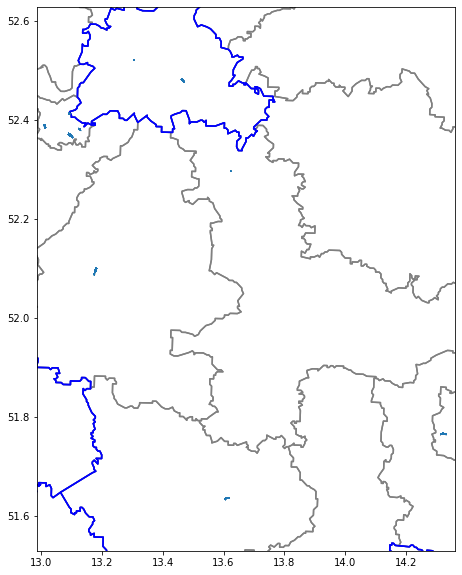

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))   #keine Ahnung was hier passiert

#Überbldung (Hinterlegen) von den Grenzen der Bundesländer in blau und den Kreisen in grau
bland = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/4_kreise/1_sehr_hoch.geo.json')
bland.boundary.plot(ax=ax, color='gray') 
bland = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json')
bland.boundary.plot(ax=ax, color='blue')  

#BBox aller Überholvorgänge
boundary = gdf_25w.total_bounds

#setzen des Plotausschnitts (0,2% mehr als BBox links und rechts)
xlim = ([boundary[0]*0.998, boundary[2]*1.002])
ylim = ([boundary[1]*0.998, boundary[3]*1.002])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf_25w.plot(ax=ax)

In [22]:
gdf_dichte = gdf_merged
datum=date.today().strftime("%y%m%d")

gdf_dichte = gdf_dichte.drop_duplicates(subset=['geometry_y']).copy()

gdf_dichte['geometry_y'] = gdf_dichte['geometry_y'].apply(wkt.loads)
gdf_dichte = gpd.GeoDataFrame(gdf_dichte, geometry='geometry_y', crs='EPSG:4326')
gdf_dichte = gdf_dichte.astype({'geometry':'string'})
gdf_dichte.to_file("../OSM-roh/OSM-OBS_"+datum+"ways-mit-Dichte.gpkg", driver="GPKG")